<a href="https://colab.research.google.com/github/ealjkj/ealjkj/blob/main/financial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the stock market with python

We will try to replicate the ITRAC algorithm in order to outperform the S&P 500.

## Getting data from an API

In [ ]:
# Getting some useful packages
!pip install alpha_vantage

# My API key:
# MDT9LRDR9TIZGJLH

     |████████████████████████████████| 1.3MB 28.8MB/s 
     |████████████████████████████████| 296kB 35.5MB/s 
     |████████████████████████████████| 143kB 35.1MB/s 


In [ ]:
import pandas as pd 
import numpy as np
from alpha_vantage.timeseries import TimeSeries
import time  
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import seaborn as sns

In [ ]:
api_key = 'MDT9LRDR9TIZGJLH'
stock = 'AAPL'
ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_daily(symbol=stock, outputsize='full')
print(data.head())

            1. open  2. high   3. low  4. close   5. volume
date                                                       
2021-07-02   137.90  140.000  137.745    139.96  78945572.0
2021-07-01   136.60  137.330  135.760    137.27  52485781.0
2021-06-30   136.17  137.410  135.870    136.96  63261393.0
2021-06-29   134.80  136.490  134.350    136.33  64556081.0
2021-06-28   133.41  135.245  133.350    134.78  62111303.0


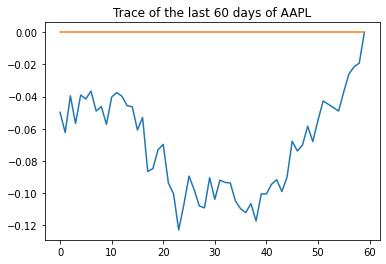

In [ ]:
# Plot the closing positions 
num_of_days = 60
close = data['4. close']
y = close[0:num_of_days].to_numpy()
y = np.flip(y,0) # The first element on data is the last day. We have to flip the array
y = y/y[-1]-1
plt.plot(y)

#Plot the 0% line
plt.plot(np.zeros(num_of_days), '-')

plt.title('Trace of the last 60 days of ' + stock)
plt.show()

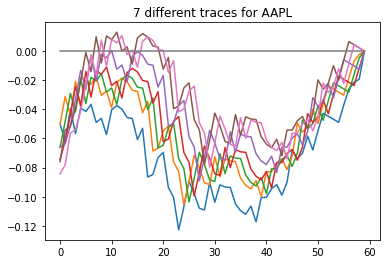

In [ ]:
# Plot multiple traces
num_of_traces = 7
for idx in range(0,num_of_traces):
  y = close[idx:num_of_days+idx].to_numpy()
  y = np.flip(y,0) # The first element on data is the last day. We have to flip the array
  y = y/y[-1]-1
  plt.plot(y)

# Plot the 0% line
plt.plot(np.zeros(num_of_days), '-')

# Details
plt.title(f'{num_of_traces} different traces for {stock}')
plt.show()


In [ ]:
# Create a hxw grid
h = 50
w = 60

# This values are temporal
max_h = 0.02
min_h = -0.12
min_w = 0
max_w = num_of_days

# Steps
h_step = (max_h - min_h)/h
w_step = (max_w - min_w)/w 

y = close[1:num_of_days].to_numpy()
y = np.flip(y,0) # The first element on data is the last day. We have to flip the array
y, label = y/y[-1]-1, close[0]/y[-1]-1
x = np.linspace(0,max_w-1,len(y))

def create_grid(x, y, h, w, label, max_h=0.02, min_h=-0.12, max_w=num_of_days, min_w=0):
  grid = np.zeros((h,w))
  for i,f_i in zip(x, y):
    x_interval = int((i-min_w)//w_step)
    y_interval = int((f_i-min_h)//h_step)
    try:
      if label >0:
        grid[y_interval, x_interval] = 1
      else:
        grid[y_interval, x_interval] = -1
    except:
      print(f'--There is a problem at the {i,f_i} iteration',y_interval, x_interval)
  return grid 

grid = create_grid(x,y,h,w,label)

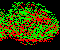

In [ ]:
# Plot the grid
img = Image.new(mode='RGB', size=(w,h), color=(0, 0, 255))
img = np.array(img)
img.setflags(write=1)

for i in range(grid.shape[0]):
  for j in range(grid.shape[1]):
    if grid[i,j] > 0:
      img[i,j] = np.array([0,255,0])
    elif grid[i,j] < 0:
      img[i,j] = np.array([255,0,0])
    else:
      img[i,j] = np.array([0,0,0])

img = Image.fromarray(img)
img = ImageOps.flip(img)
img


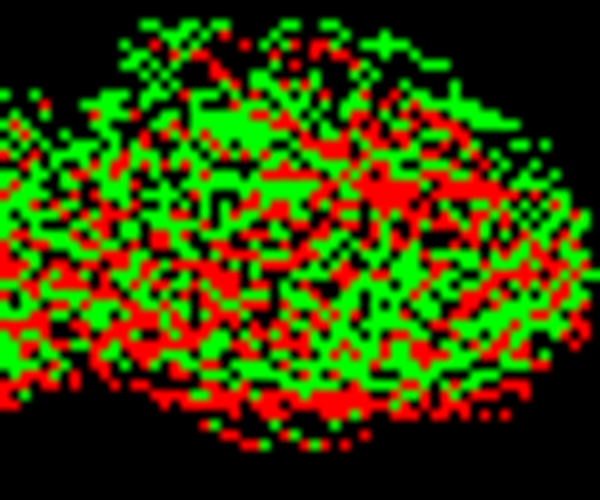

In [ ]:
#Resize the image,
img = img.resize(size=(600, 500))
img

0.23251994960100794 -0.15720312936574457


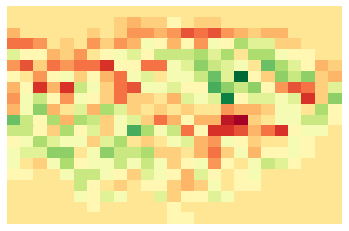

In [ ]:
# Create a hxw grid
num_of_traces_grid =90
h = 20
w = 25
grid = np.zeros((h,w))

# This values are temporal
max_h = max([max(close[idx:num_of_days+idx].to_numpy()/close[idx:num_of_days+idx].to_numpy()[-1]-1) for idx in range(1,num_of_traces_grid)])+0.03
min_h = min([min(close[idx:num_of_days+idx].to_numpy()/close[idx:num_of_days+idx].to_numpy()[-1]-1) for idx in range(1,num_of_traces_grid)])+0.03
min_w = 0
max_w = num_of_days

print(max_h, min_h)
# Steps
h_step = (max_h - min_h)/h
w_step = (max_w - min_w)/w 
for idx in range(1,num_of_traces_grid+1):
  y = close[idx:num_of_days+idx].to_numpy()
  y = np.flip(y,0) # The first element on data is the last day. We have to flip the array
  y, label = y/y[-1]-1, close[idx-1]/y[-1]-1
  x = np.linspace(0,max_w-1,len(y))

  grid+=create_grid(x,y,h,w,label,max_h = max_h, min_h = min_h)

ax = sns.heatmap(grid, cmap="RdYlGn", xticklabels=False, yticklabels=False, cbar=False)
#plt.title(f'{num_of_traces_grid} diferent traces heatmap')
plt.show()

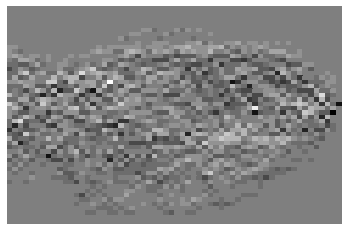

In [ ]:
ax2 = sns.heatmap(grid, cmap="binary", xticklabels=False, yticklabels=False, cbar=False)
plt.title='hi'
plt.show()